In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from dateutil.relativedelta import \
    relativedelta
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

**Task 1**

• Analyze merchant transaction data from January 1, 2033, to January 1, 2035.

In [ ]:
raw_data = pd.read_csv('Homework8.csv')
raw_data.head(3)

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17 23:34:14,6349
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854
2,3,5608f200cf,2034-04-30 01:29:42,789


In [ ]:
raw_data['usd'] = raw_data['amount_usd_in_cents'] / 100 # I prefer to work with $$$ instead of cents.
raw_data['time'] = pd.to_datetime(raw_data['time'])
raw_data.sort_values(by='time', inplace=True)
raw_data.head(3)

,Unnamed: 0,merchant,time,amount_usd_in_cents,usd
731681,731682,3e72388b82,2033-01-01 09:38:32,4335,43.35
157656,157657,32cd721943,2033-01-01 12:53:52,6019,60.19
1471394,1471395,a8ff2d667e,2033-01-01 15:08:55,3942,39.42


In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)

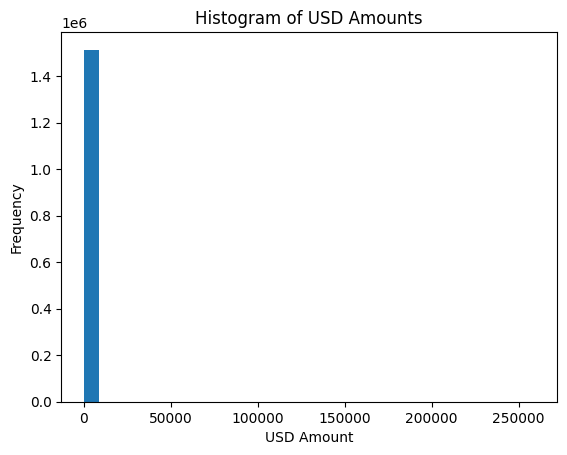

In [ ]:
plt.hist(raw_data['usd'], bins=30)
plt.xlabel('USD Amount')
plt.ylabel('Frequency')
plt.title('Histogram of USD Amounts')
plt.show()

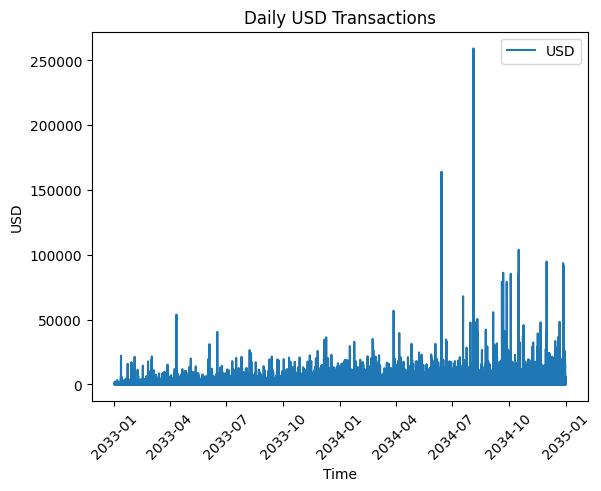

In [ ]:
plt.plot(raw_data['time'], raw_data['usd'], label='USD')
plt.title('Daily USD Transactions')
plt.xlabel('Time')
plt.ylabel('USD')
plt.xticks(rotation=45)
plt.legend()
plt.show()

As we can see above, the time-series data is not smooth. Will need to use smoothing techniques to better understand the data.

In [ ]:
raw_data = raw_data[raw_data['usd'] < 55_000]

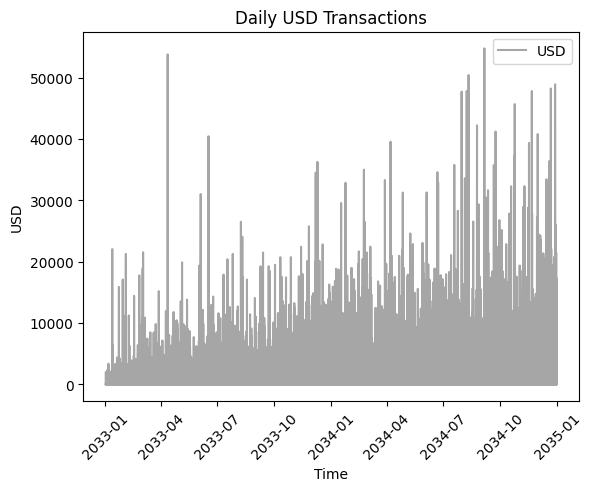

In [ ]:
plt.plot(raw_data['time'], raw_data['usd'], label='USD', color='grey', alpha=0.7)
plt.title('Daily USD Transactions')
plt.xlabel('Time')
plt.ylabel('USD')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**• Resample the merchant transaction data to obtain daily transaction sums (in Dollars).**

In [ ]:
daily_sums = raw_data.resample('D', on='time').sum()
daily_sums.head(3)

,Unnamed: 0,merchant,amount_usd_in_cents,usd
time,,,,
2033-01-01,34120440,3e72388b8232cd721943a8ff2d667ecad5cd6286878047...,441540,4415.40
2033-01-02,61766197,878047f4b9a16f6749e46ec7b50636a03a7df510a03a7d...,475862,4758.62
2033-01-03,67208763,878047f4b96ec7b5063632cd721943793344d14905ef18...,628353,6283.53


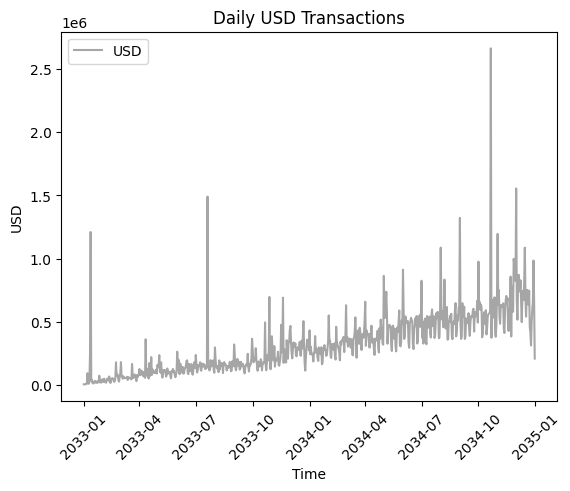

In [ ]:
plt.plot(daily_sums.index, daily_sums['usd'], label='USD', color='grey', alpha=0.7)
plt.title('Daily USD Transactions')
plt.xlabel('Time')
plt.ylabel('USD')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
def moving_average(series, n):
    return np.average(series[-n:])
moving_average(daily_sums['usd'], 40)

707721.342

In [ ]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], color='black',label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

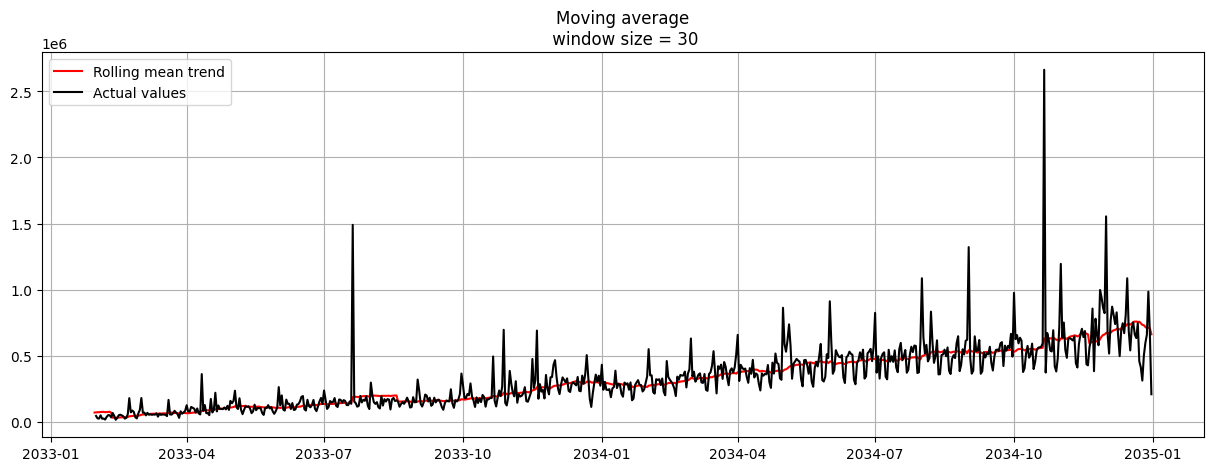

In [ ]:
plotMovingAverage(daily_sums['usd'],30)

As we can see above, plotting the rolling average allows us to smooth and clearly see the direction of the data.

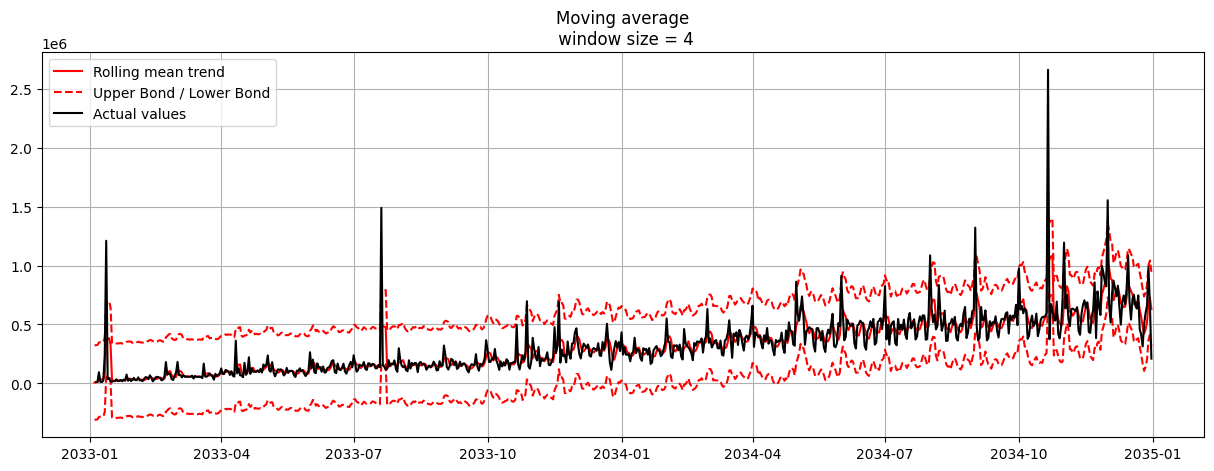

In [ ]:
plotMovingAverage(daily_sums['usd'], 4, plot_intervals=True)

• Apply Holt-Winters method to capture seasonality, trend, and level in the daily transaction data.

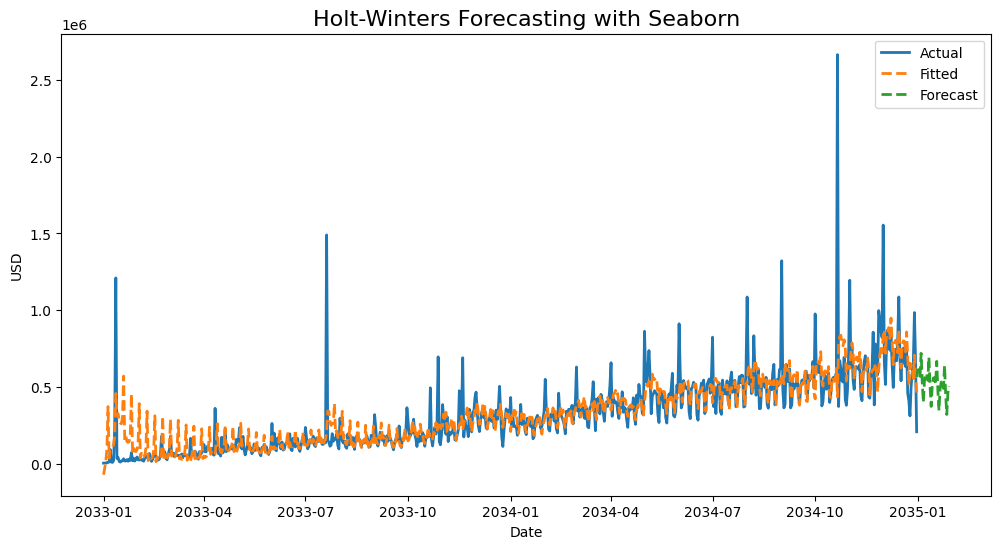

In [ ]:
model = ExponentialSmoothing(daily_sums['usd'], trend='add', seasonal='add', seasonal_periods=7)
fit = model.fit()
forecast = fit.forecast(30)

plt.figure(figsize=(12, 6))

sns.lineplot(x=daily_sums.index, y=daily_sums['usd'], label='Actual', linewidth=2)

sns.lineplot(x=daily_sums.index, y=fit.fittedvalues, label='Fitted', linestyle='--', linewidth=2)

forecast_index = pd.date_range(start=daily_sums.index[-1], periods=30, freq='D')
sns.lineplot(x=forecast_index, y=forecast, label='Forecast', linestyle='--', linewidth=2)

plt.title('Holt-Winters Forecasting with Seaborn', fontsize=16)
plt.xlabel('Date')
plt.ylabel('USD')

plt.legend()

plt.show()

• For Holt-Winters, Use time series cross-validation to determine the values of the model parameters

In [ ]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method

    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [ ]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):

    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = np.abs(model.result[-len(test) :])
        actual = values[test]
        error = np.abs(loss_function(predictions, actual))
        errors.append(error)

    return np.mean(np.array(errors))

In [ ]:
%%time
daily_sums_80 = daily_sums.sample(frac=0.8, random_state=42).copy()  # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss function
opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(daily_sums_80['usd'], mean_squared_log_error),
    method="TNC",
    bounds=((0, 1), (0, 1), (0, 1)),
)

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(
    daily_sums_80['usd'],
    slen=24,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=50,
    scaling_factor=3,
)
model.triple_exponential_smoothing()

0.0005255971988106234 0.08981977673808172 0.0
CPU times: user 4.1 s, sys: 40.3 ms, total: 4.14 s
Wall time: 4.26 s


In [ ]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label="Model")
    plt.plot(series.values, label="Actual")
    error = mean_absolute_percentage_error(series.values, model.result[: len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[: len(series)]] = series.values[
            series.values < model.LowerBond[: len(series)]
        ]
        anomalies[series.values > model.UpperBond[: len(series)]] = series.values[
            series.values > model.UpperBond[: len(series)]
        ]
        plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(
            x=range(0, len(model.result)),
            y1=model.UpperBond,
            y2=model.LowerBond,
            alpha=0.2,
            color="grey",
        )

    plt.vlines(
        len(series),
        ymin=min(model.LowerBond),
        ymax=max(model.UpperBond),
        linestyles="dashed",
    )
    plt.axvspan(len(series) - 20, len(model.result), alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

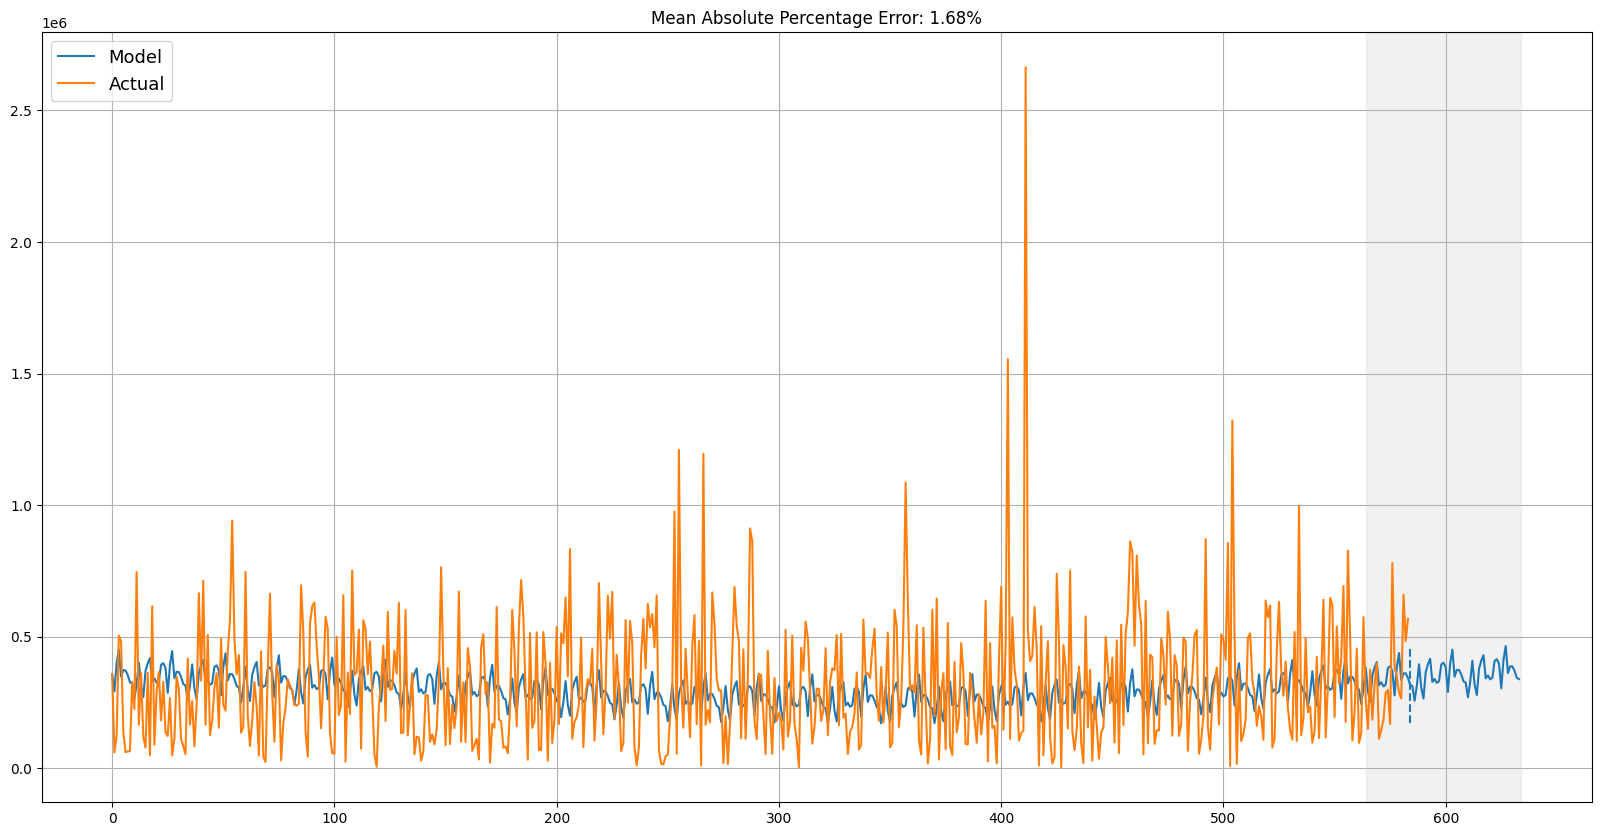

In [ ]:
plotHoltWinters(daily_sums_80['usd'])

Task 2






**• Create new features based on lagged values of the time series for linear regression and random forest models. You can also include any additional features you want.**

In [ ]:
for i in range(1, 8):
    daily_sums[f'lag_{i}'] = daily_sums['usd'].shift(i)

daily_sums['rolling_mean_7'] = daily_sums['usd'].rolling(window=7).mean()
daily_sums['rolling_std_7'] = daily_sums['usd'].rolling(window=7).std()

daily_sums.dropna(inplace=True)

X = daily_sums[['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7', 'rolling_std_7']]
y = daily_sums['usd']

**• Implement a linear regression model using the newly created features.**

In [ ]:
scaler = MinMaxScaler()
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
lr.score(X_test_scaled, y_test)

0.27209378181292354

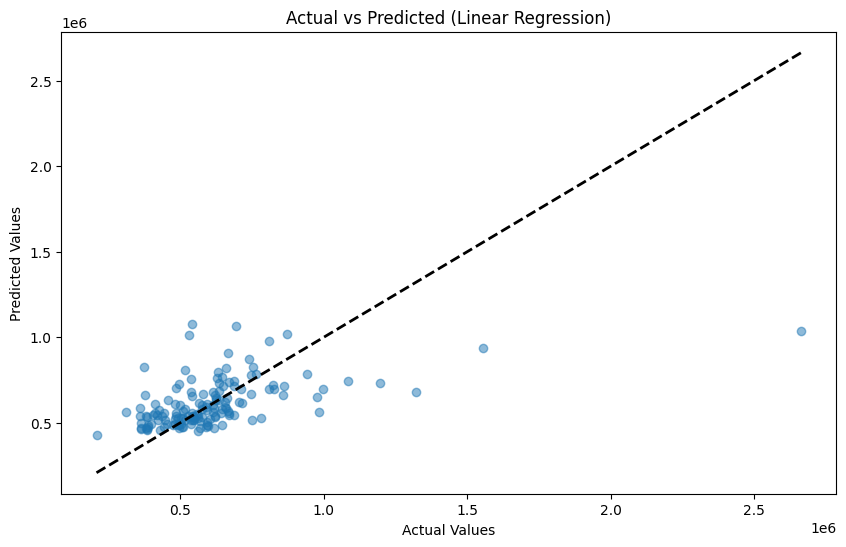

MAPE: 0.20755842236351274
RMSE: 214712.4844305802
MAE: 127376.11502279267


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Linear Regression)')
plt.show()
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred_lr)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred_lr, squared=False)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lr)}')

In [ ]:
X_train_scaled_sm = sm.add_constant(X_train_scaled)

model_sm = sm.OLS(y_train, X_train_scaled_sm).fit()

X_test_scaled_sm = sm.add_constant(X_test_scaled)

predictions = model_sm.get_prediction(X_test_scaled_sm)

predictions_summary = predictions.summary_frame(alpha=0.05)

confidence_intervals = predictions_summary[['mean_ci_lower', 'mean_ci_upper']]
print("Confidence Intervals for predictions:\n", confidence_intervals)


Confidence Intervals for predictions:
      mean_ci_lower  mean_ci_upper
0        487165.39      545437.27
1        457981.48      516153.48
2        567685.18      611130.68
3        565845.75      606498.09
4        516085.54      563825.87
..             ...            ...
140      583136.51      634497.32
141      563990.14      611841.19
142      543780.06      587129.65
143      504989.86      581879.84
144      389139.46      473601.66

[145 rows x 2 columns]


**• Implement a random forest regression model using the newly created features.**



In [ ]:
rf = RandomForestRegressor()

param_grid = {
    'n_estimators': [1, 5, 10,50,100],
    'max_depth': [None,1, 5, 10, 50],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_scaled, y_test)
print(f"Test set score: {test_score}")


Best parameters: {'max_depth': 50, 'min_samples_leaf': 4, 'n_estimators': 100}
Test set score: -0.007062244288655872


In [ ]:
rf = RandomForestRegressor(max_depth=10, min_samples_leaf=1, n_estimators=100)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
rf.score(X_test_scaled, y_test)

-0.026537479081711446

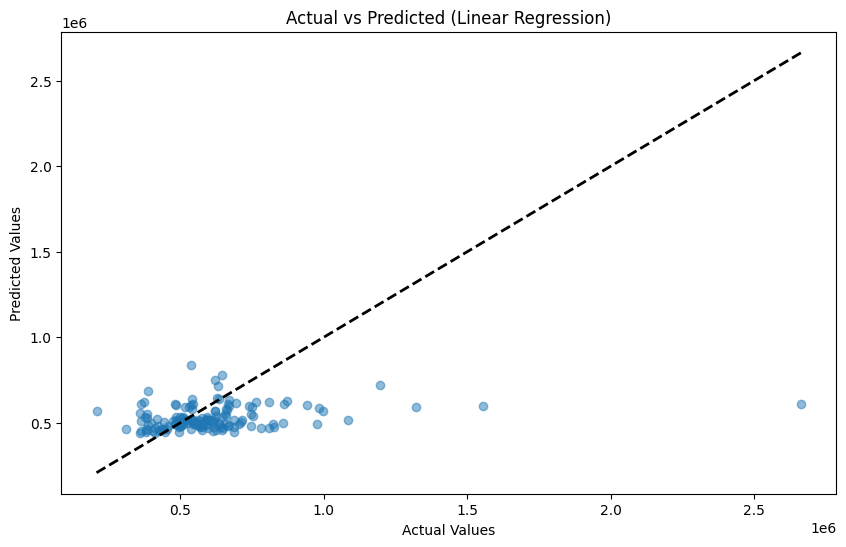

MAPE: 0.2146253319209309
RMSE: 254980.5112446408
MAE: 144760.36765240232


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Linear Regression)')
plt.show()
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred_rf)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred_rf, squared=False)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_rf)}')

In [ ]:
X.merge(y, left_index=True, right_index=True).corr()

,lag_1,lag_2,lag_3,rolling_mean_7,rolling_std_7,usd
lag_1,1.00,0.67,0.64,0.84,0.49,0.67
lag_2,0.67,1.00,0.67,0.84,0.49,0.63
lag_3,0.64,0.67,1.00,0.84,0.48,0.63
rolling_mean_7,0.84,0.84,0.84,1.00,0.58,0.83
rolling_std_7,0.49,0.49,0.48,0.58,1.00,0.49
usd,0.67,0.63,0.63,0.83,0.49,1.00


In [ ]:
tree_predictions = np.array([tree.predict(X_test_scaled) for tree in rf.estimators_])

mean_predictions = np.mean(tree_predictions, axis=0)

std_predictions = np.std(tree_predictions, axis=0)

lower_bounds = mean_predictions - 1.96 * std_predictions
upper_bounds = mean_predictions + 1.96 * std_predictions

print("Lower bounds:\n", lower_bounds.min())
print("Upper bounds:\n", upper_bounds.max())


Lower bounds:
 126823.77207778528
Upper bounds:
 1348389.5354020754


**See Above LR and RF models For the three models**

• Calculate and compare the MAPE for each model to assess their accuracy.

• Include the confidence intervals for each model’s forecasts.